# Project Milestone P2

### Objective

This notebook is a creative extension concerning the article _Comparing Random Forest with Logistic Regression for
Predicting Class-Imbalanced Civil War Onset Data_ by D.Muchlinski et al (2016).
We aim to TODO

### Libraries

- Scikit-learn
- Numpy
- Pandas
- Matplotlib
- Seaborn

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, auc, roc_curve
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

## 1. Data Loading and preparation

In [2]:
replication_features = ["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]

data = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)

# Retreiving the labels
y = data['warstds']
X = data.drop('warstds', axis=1)

print('Nb of country-years: {}'.format(len(X)))
X.head()

Nb of country-years: 7140


,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,polch98,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,0,0,0,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,0.143299
1,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,0,0,0,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000
2,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,0,0,0,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000
3,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,0,0,0,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000
4,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,0,0,0,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000


In [3]:
# We verify no data is missing
len(X[X.isna().any(axis=1)])

0

Let us reproduce Figure 2 from the article, this will serve as a comparison point for our extensions.
In the article, Random Forests are compared to "against three well-known logistic models of civil war onset", namely those developped by:
- Collier and Hoeffler (2004) 
- Fearon and Laitin (2003)
- Hegre and Sambanis (2006).

Let us load the corresponding features.

In [4]:
#Fearon and Laitin (2003) 
FL_features = ["warhist", "ln_gdpen", "lpopns", "lmtnest", "ncontig", "oil",
               "nwstate", "inst3", "pol4", "ef", "relfrac"] 
X_FL = X[FL_features]

#Collier and Hoeffler (2004)
CH_features = ["sxpnew", "sxpsq", "ln_gdpen", "gdpgrowth","warhist", "lmtnest",
               "ef", "popdense", "lpopns", "coldwar", "seceduc","ptime"]
X_CH = X[CH_features]

#Hegre and Sambanis (2006) 
HS_features = ["lpopns", "ln_gdpen", "inst3", "parreg", "geo34",
    "proxregc", "gdpgrowth", "anoc", "partfree", "nat_war", "lmtnest",
    "decade1", "pol4sq", "nwstate", "regd4_alt", "etdo4590", "milper", "geo1",
    "tnatwar", "presi"]
X_HS = X[HS_features]

## 2. Fitting and comparing the models

We will run all three different logistic models through two methods each, namely a regular and a L2-penalized, logistic regressions. Note here that L2 regularization is used instead of Firth regularization which is the one used in the article. We justify this choice by arguing that the main idea of the paper was using penalty to adjust regression to the rare events, and thus it is not important which penalty it is.

In [5]:
# Creating the methods
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
gbc = GradientBoostingClassifier(random_state=0)
random_forest = RandomForestClassifier(n_estimators=1000)

In [6]:
# TODO erase
def plot_multi_roc(titles, methods, datasets, models, random_forest, y):
    """
    Reproduces Figure 2 from the article, i.e. plot ROC curves for each model on their corresponding datasets.
    """
    
    fig, axes = plt.subplots(1,len(methods), figsize=(len(methods)*6.5,5))
    
    # Computing random forest only once
    y_pred_rf = cross_val_predict(random_forest, datasets[0], y, cv=10, method="predict_proba")
    
    for ax, title, method in zip(axes.flatten(), titles, methods):
        for X, model in zip(datasets, models):

            # Predict the probabilities with a cross validation
            if(model == 'Random Forest'):
                y_pred = y_pred_rf
            else:
                y_pred = cross_val_predict(method, X, y, cv=10, method="predict_proba")

            # Compute the False Positive Rate and True Positive Rate
            fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
            # Compute the area under the fpt-tpf curve
            auc_score = auc(fpr, tpr)

            # Plotting results
            ax.plot(fpr, tpr, label='{}: {:.2f}'.format(model, auc_score))
            ax.set_title(title)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()
            
            
def plot_multi_roc_ci(titles, methods, datasets, models, random_forest, y):
    """
    Reproduces Figure 2 from the article, i.e. plot ROC curves for each model on their corresponding datasets.
    """
    
    fig, axes = plt.subplots(1,len(methods), figsize=(len(methods)*6.5,5))
    
    # Computing random forest only once
    y_pred_rf = cross_val_predict(random_forest, datasets[0], y, cv=10, method="predict_proba")
    
    for ax, title, method in zip(axes.flatten(), titles, methods):
        for X, model in zip(datasets, models):

            # Predict the probabilities with a cross validation
            if(model == 'Random Forest'):
                y_pred = y_pred_rf
                aucs = cross_val_score(random_forest, X, y, cv=10, scoring='roc_auc')
            else:
                y_pred = cross_val_predict(method, X, y, cv=10, method="predict_proba")
                aucs = cross_val_score(method, X, y, cv=10, scoring='roc_auc')

            # Compute the False Positive Rate and True Positive Rate
            fpr, tpr, _ = roc_curve(y, y_pred[:, 1])
            # Compute the area under the fpt-tpf curve
            #auc_score = auc(fpr, tpr)
            auc_score = aucs.mean()
            # Compute its standard deviation
            auc_std = aucs.std()
            
            # Plotting results
            ax.plot(fpr, tpr, label='{}: {:.2f} (+/- {:.2f})'.format(model, auc_score, auc_std*2))
            ax.set_title(title)
            ax.set_xlabel("False Positive Rate")
            ax.set_ylabel("True Positive Rate")
            ax.legend()

In [7]:
def compare_models_aucs_with_random_forest(titles, methods, datasets, models, random_forest, random_forest_dataset, y):
    rf_aucs = cross_val_score(random_forest, random_forest_dataset, y, cv=10, scoring="roc_auc")
    
    for title, method in zip(titles, methods):
        print("Testing for method : " + title)
        for X, model in zip(datasets, models):
            
            model_aucs = cross_val_score(method, X, y, cv=10, scoring='roc_auc')
            stat, p_value = stats.kstest(rf_aucs, model_aucs)
            
            print("p-value between random forest and " + model + " is " + str(p_value))
        print("===============================")

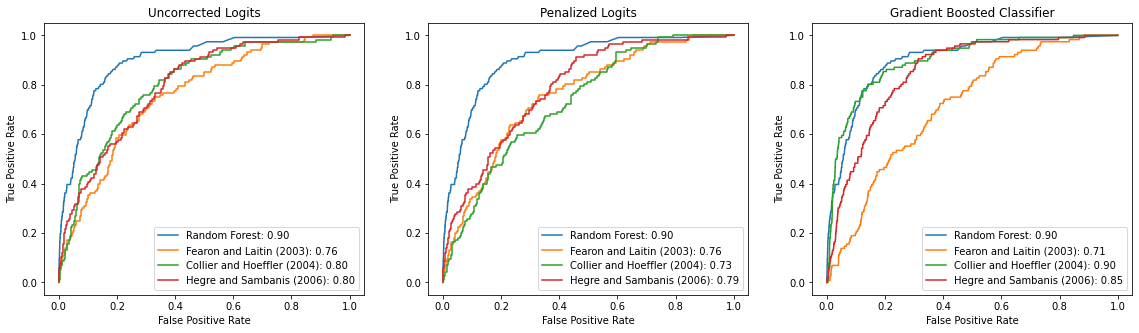

In [7]:
# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X, X_FL, X_CH, X_HS]
models = ['Random Forest', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']


# Fitting models and plotting results            
plot_multi_roc(titles, methods, datasets, models, random_forest, y)

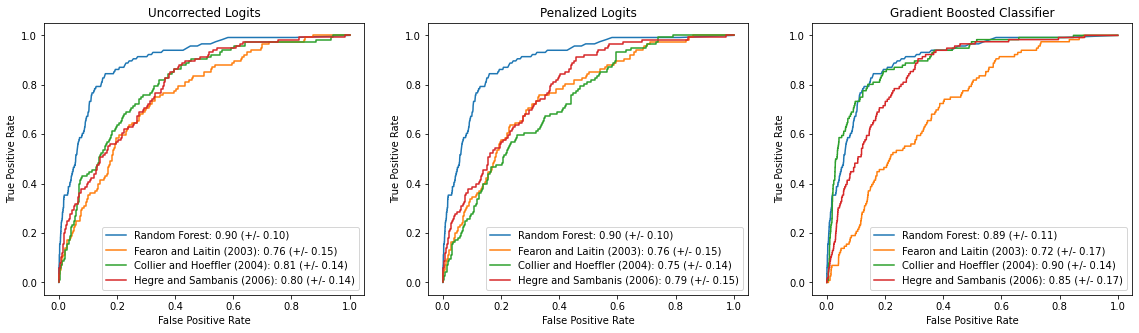

In [9]:
# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X_FL, X_CH, X_HS]
models = ['Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']


# Fitting models and plotting results            
plot_multi_roc_ci(titles, methods, datasets, models, random_forest, y)

In [29]:
# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X_FL, X_CH, X_HS]
models = ['Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']
compare_models_aucs_with_random_forest(titles, methods, datasets, models, random_forest, X, y)

Testing for method : Uncorrected Logits
p-value between random forest and Fearon and Laitin (2003) is 0.002056766762649115
p-value between random forest and Collier and Hoeffler (2004) is 0.05244755244755244
p-value between random forest and Hegre and Sambanis (2006) is 0.012340600575894691
Testing for method : Penalized Logits
p-value between random forest and Fearon and Laitin (2003) is 0.002056766762649115
p-value between random forest and Collier and Hoeffler (2004) is 0.00021650176448938054
p-value between random forest and Hegre and Sambanis (2006) is 0.002056766762649115
Testing for method : Gradient Boosted Classifier
p-value between random forest and Fearon and Laitin (2003) is 0.002056766762649115
p-value between random forest and Collier and Hoeffler (2004) is 0.7869297884777761
p-value between random forest and Hegre and Sambanis (2006) is 0.41752365281777043


From the first two graphs, one can easily recognise the results of the orinial paper (TODO std of AUC to justify minor diff inside CI ?). Indeed, when transitioning from uncorrected logits to penalized logits, we observe that the AUC score for Random Forest, Fearon & Laitin, and Hegre & Sambanis do not (or barely) change, while the AUC score for Collier & Hoeffler diminishes substantially.

TODO comment on gradient boosted classifier

In [8]:
def print_f1_scores(titles, methods, datasets, models, random_forest, y):

    
    for title, method in zip(titles, methods):
        print("F1 score for " + title)
        for X, model in zip(datasets, models):
            scores = cross_val_score(method, X, y, cv=10, scoring='f1')
            print(model + " Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("===================================")    

In [9]:
# Methods
titles = ['Random Forest', 'Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [random_forest, logistic, logistic_pen, gbc]

# Models
datasets = [X, X_FL, X_CH, X_HS]
models = ['All features', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

print_f1_scores(titles, methods, datasets, models, random_forest, y)

F1 score for Random Forest
All features Accuracy: 0.10 (+/- 0.18)
Fearon and Laitin (2003) Accuracy: 0.07 (+/- 0.15)
Collier and Hoeffler (2004) Accuracy: 0.24 (+/- 0.19)
Hegre and Sambanis (2006) Accuracy: 0.09 (+/- 0.20)
F1 score for Uncorrected Logits
All features Accuracy: 0.00 (+/- 0.00)
Fearon and Laitin (2003) Accuracy: 0.00 (+/- 0.00)
Collier and Hoeffler (2004) Accuracy: 0.00 (+/- 0.00)
Hegre and Sambanis (2006) Accuracy: 0.02 (+/- 0.09)
F1 score for Penalized Logits
All features Accuracy: 0.00 (+/- 0.00)
Fearon and Laitin (2003) Accuracy: 0.00 (+/- 0.00)
Collier and Hoeffler (2004) Accuracy: 0.00 (+/- 0.00)
Hegre and Sambanis (2006) Accuracy: 0.00 (+/- 0.00)
F1 score for Gradient Boosted Classifier
All features Accuracy: 0.28 (+/- 0.30)
Fearon and Laitin (2003) Accuracy: 0.06 (+/- 0.14)
Collier and Hoeffler (2004) Accuracy: 0.29 (+/- 0.28)
Hegre and Sambanis (2006) Accuracy: 0.12 (+/- 0.27)


## 3. Resampling data with SMOTE

One of our proposals is to use resampling techniques and study their effect on both the linear models and the random forest techniques. Indeed, it may well be that the poor performance of linear models relative to random forest is due to the severe imbalance of the CWD (roughly a 1:100 ratio).
To tackle this, we intend to use one of the most commonly used oversampling methods: the SMOTE (Synthetic Minority Oversampling Technique).

The SMOTE creates new instances of the minority class, and makes use of the K-nearest neighbors procedure to do so. The algorithm loops through all the "real" minority class instances. At each iteration, it finds its K nearest neighbors, and then creates "synthetic" minority class instances in the interval between the "real" instance and its "real" neighbors, such that the new instances are convex combination of the original instance and one of its neighbors. The procedure can be visualised in the following images ([source](https://rikunert.com/SMOTE_explained)).

<img src="img/SMOTE_1.png" width=600>

<img src="img/SMOTE_2.png" width=600>

In our problem, the number of genereated instances is such that the classes are balanced after resampling. 

In [31]:
print("Before SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y==1), sum(y==0)))

sm = SMOTE(random_state=23)
X_res, y_res = sm.fit_sample(X, y.ravel())

print("After SMOTE, counts of labels 'warstds' ('1': {}, '0': {}".format(sum(y_res==1), sum(y_res==0)))

Before SMOTE, counts of labels 'warstds' ('1': 116, '0': 7024
After SMOTE, counts of labels 'warstds' ('1': 7024, '0': 7024


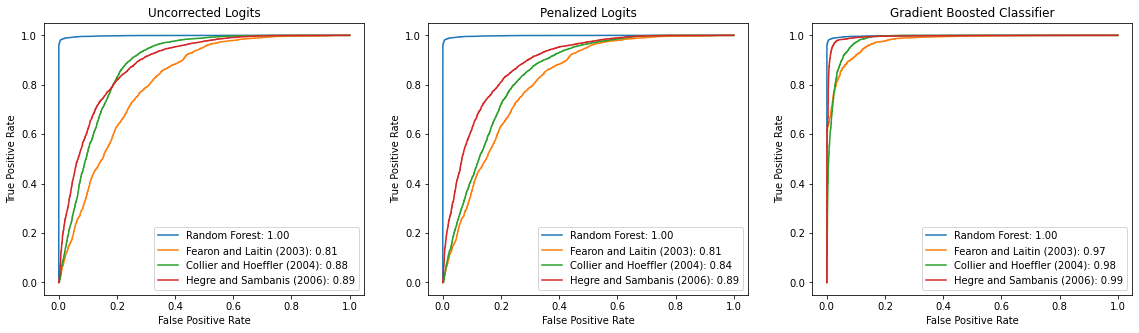

In [32]:
# TODO make a function
#Fearon and Laitin (2003) 
X_FL_res = X_res[FL_features]

#Collier and Hoeffler (2004)
X_CH_res = X_res[CH_features]

#Hegre and Sambanis (2006) 
X_HS_res = X_res[HS_features]


# Creating the methods anew
logistic = LogisticRegression(penalty='none', solver='lbfgs', max_iter=10000)
logistic_pen = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=10000)
random_forest = RandomForestClassifier(n_estimators=1000)

# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X_res, X_FL_res, X_CH_res, X_HS_res]
models = ['Random Forest', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

# Fitting models and plotting results            
plot_multi_roc(titles, methods, datasets, models, random_forest, y_res)

Resampling with SMOTE seems to have a powerful positive effect on the predictive power of all models. 

In [ ]:
# Methods
titles = ['Random Forest', 'Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [random_forest, logistic, logistic_pen, gbc]

# Models
datasets = [X_res, X_FL_res, X_CH_res, X_HS_res]
models = ['All features', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']

print_f1_scores(titles, methods, datasets, models, random_forest, y_res)

F1 score for Random Forest
All features Accuracy: 0.98 (+/- 0.03)
Fearon and Laitin (2003) Accuracy: 0.90 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.96 (+/- 0.03)
Hegre and Sambanis (2006) Accuracy: 0.98 (+/- 0.03)
F1 score for Uncorrected Logits
All features Accuracy: 0.79 (+/- 0.06)
Fearon and Laitin (2003) Accuracy: 0.75 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.83 (+/- 0.04)
Hegre and Sambanis (2006) Accuracy: 0.82 (+/- 0.04)
F1 score for Penalized Logits
All features Accuracy: 0.79 (+/- 0.05)
Fearon and Laitin (2003) Accuracy: 0.75 (+/- 0.06)
Collier and Hoeffler (2004) Accuracy: 0.79 (+/- 0.06)
Hegre and Sambanis (2006) Accuracy: 0.82 (+/- 0.04)
F1 score for Gradient Boosted Classifier
All features Accuracy: 0.98 (+/- 0.03)
Fearon and Laitin (2003) Accuracy: 0.91 (+/- 0.04)


In [34]:
# Methods
titles = ['Uncorrected Logits', 'Penalized Logits', 'Gradient Boosted Classifier']
methods = [logistic, logistic_pen, gbc]

# Models
datasets = [X_FL_res, X_CH_res, X_HS_res]
models = ['Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']
compare_models_aucs_with_random_forest(titles, methods, datasets, models, random_forest, X_res, y_res)

Testing for method : Uncorrected Logits
p-value between random forest and Fearon and Laitin (2003) is 1.0825088224469026e-05
p-value between random forest and Collier and Hoeffler (2004) is 1.0825088224469026e-05
p-value between random forest and Hegre and Sambanis (2006) is 1.0825088224469026e-05
Testing for method : Penalized Logits
p-value between random forest and Fearon and Laitin (2003) is 1.0825088224469026e-05
p-value between random forest and Collier and Hoeffler (2004) is 1.0825088224469026e-05
p-value between random forest and Hegre and Sambanis (2006) is 1.0825088224469026e-05
Testing for method : Gradient Boosted Classifier
p-value between random forest and Fearon and Laitin (2003) is 1.0825088224469026e-05
p-value between random forest and Collier and Hoeffler (2004) is 1.0825088224469026e-05
p-value between random forest and Hegre and Sambanis (2006) is 0.002056766762649115


# Urban unrest dataset

## Loading the data
Description of features :

* GWNO : Country code
* BYEAR : Begin year
* NPART : Total Number of Active Participants and People Directly Affected
    * 1 less than 10
    * 2 10-100
    * 3 101-1,000
    * 4 1,001-10,000
    * 5 10,001-100,000
    * 6 100,001-1,000,000
    * 7 over 1,000,000
    * 11 Unknown, but probably relatively small number (less than 1,000)
    * 12 Unknown, but probably large number (1,000-100,000)
    * 13 Unknown, but probably very large number (over 100,000)
    * 99 Unknown
    
* NDEATH : Total Number of Deaths Reported (9 digit numeric; cardinal)
Records the best estimate of the number of persons killed as a direct result of the
event. Estimates in ranges are separated by a dash in increasing order, e.g. “100-
800”. If the reported numbers are only a smaller sample of the total, this becomes
the lowest possible estimate and is preceded with a “greater than” symbol (“>”). If
the highest possible estimate is given, such as a combined estimate for multiple
cities, precede with a “lower than” symbol (“<”).
    * -99 Unknown (with the minus sign)
    
    
We first load the data from the Excel file. We only keep 4 columns, the first two will be useful to merge this DataFrame with the CWD and the last two ones will be used to determine our measure of urban unrest

In [70]:
def string_to_int(ndeath):

    ndeath = ndeath.replace(">", "").replace("<", "").replace("=", "").replace(" ", "")
    if "--" in ndeath:
        ndeaths = list(map(int, ndeath.split("--")))
        return sum(ndeaths) / len(ndeaths)
    elif  "-" in ndeath:
        ndeaths = list(map(int, ndeath.split("-")))
        return sum(ndeaths) / len(ndeaths)
    else:
        return int(ndeath)

In [166]:
events = pd.read_excel("data/events.xlsx", usecols = ["GWNO", "BYEAR", "PTYPE"]).drop_duplicates(subset=["BYEAR", "GWNO"])
events = events[events["PTYPE"].isin([60, 61, 62]) == False]
events["has_conflict"] = 1

In [167]:
events

,GWNO,PTYPE,BYEAR,has_conflict
5,437,51,1985,1
19,437,31,1993,1
25,437,51,1999,1
27,437,31,2000,1
33,437,31,2001,1
...,...,...,...,...
8980,371,51,1996,1
8981,371,50,1999,1
8987,371,40,2004,1
8999,371,51,2012,1


To merge the CWD with the PRIO dataset, we need to add the `cowcode` and `year` features.

Then we can merge the two datasets. As we wish to keep all entry points of the CWD, we perform a left join. The NaN values can then be infered to be 0 as we assume there was no social unrest, thus no participants and no deaths.

**Question : Do we keep the warstds feature ? I'd say yes**

In [168]:
replication_features += ["cowcode", "year"]
data = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)
cwd_and_events = pd.merge(data[data["year"] >= 1960], events, left_on = ["cowcode", "year"], right_on = ["GWNO", "BYEAR"], how="left").drop(["GWNO", "BYEAR", "cowcode", "year", "PTYPE"], axis = 1).fillna(0)

In [169]:
cwd_and_events

,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,autch98,demch98,...,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc,has_conflict
0,0,192,0.0,117.804310,129057.9163,118.807096,72.699552,1383.666626,0,0,...,1.0,0.0,0.052972,100.0,1,0,0,0,3.010000e-36,0.0
1,0,204,0.0,15.661860,47000.0000,60.000000,11.157030,1324.000000,0,0,...,1.0,0.0,0.052912,100.0,1,0,0,0,7.520000e-37,0.0
2,0,216,0.0,15.982750,47000.0000,77.000000,12.550610,1351.333374,0,0,...,1.0,0.0,0.052754,100.0,1,0,0,0,1.880000e-37,0.0
3,0,228,0.0,16.321039,47000.0000,90.000000,14.227640,1366.333374,0,0,...,1.0,0.0,0.052624,100.0,1,0,0,0,4.700000e-38,0.0
4,0,240,0.0,16.675520,47000.0000,100.000000,26.035509,1451.333374,0,0,...,1.0,0.0,0.052699,100.0,1,0,0,0,1.180000e-38,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5957,0,280,0.0,29.060539,46000.0000,118.121927,78.975510,3132.088135,0,0,...,0.0,0.0,0.030631,36.0,0,0,0,1,1.530000e-05,0.0
5958,0,292,0.0,118.015104,46000.0000,120.996433,72.737373,3175.846436,0,0,...,0.0,0.0,0.037878,36.0,0,0,0,1,3.810000e-06,0.0
5959,0,304,0.0,117.788461,46000.0000,121.013870,79.235222,4489.731853,0,0,...,0.0,0.0,0.052775,36.0,0,0,0,1,9.540000e-07,1.0
5960,0,316,0.0,119.010582,46000.0000,121.443041,72.858179,4516.928076,-1,0,...,0.0,0.0,0.052714,36.0,0,0,0,1,2.380000e-07,0.0


In [170]:
cwd_and_events["has_conflict"].value_counts()

0.0    4952
1.0    1010
Name: has_conflict, dtype: int64

In [171]:
cwd_and_events["warstds"].corr(cwd_and_events["has_conflict"])

0.0656261218605463

In [172]:
cwd_and_eventsom_forest = RandomForestClassifier(criterion="gini", max_depth = 100, n_estimators = 1000)

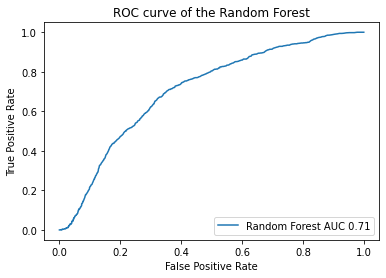

In [173]:
X_conflict = cwd_and_events.drop(["has_conflict", "warstds"], axis = 1)
y_conflict = cwd_and_events["has_conflict"]

rf_y_pred = cross_val_predict(random_forest, X_conflict, y_conflict, cv=10, method="predict_proba")
rf_fpr, rf_tpr, _ = roc_curve(y_conflict , rf_y_pred[:, 1])
rf_auc_score = auc(rf_fpr, rf_tpr)
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(rf_fpr,rf_tpr, label="Random Forest AUC {:.2f}".format(rf_auc_score))
ax.set_title("ROC curve of the Random Forest")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(loc="lower right")

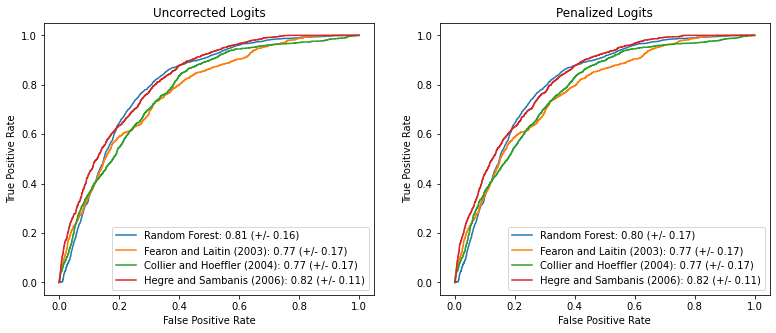

In [147]:
# TODO make a function
#Fearon and Laitin (2003) 
X_FL_conflict =  cwd_and_events[FL_features]

#Collier and Hoeffler (2004)
X_CH_conflict  =  cwd_and_events[CH_features]

#Hegre and Sambanis (2006) 
X_HS_conflict  =  cwd_and_events[HS_features]


X_conflict = cwd_and_events.drop(["has_conflict", "warstds"], axis = 1)
y_conflict = cwd_and_events["has_conflict"]

# Methods
titles = ['Uncorrected Logits', 'Penalized Logits']
methods = [logistic, logistic_pen]

# Models
datasets_conflict = [X_conflict, X_FL_conflict, X_CH_conflict, X_HS_conflict]
models_conflict = ['Random Forest', 'Fearon and Laitin (2003)', 'Collier and Hoeffler (2004)', 'Hegre and Sambanis (2006)']


# Fitting models and plotting results            
plot_multi_roc_ci(titles, methods, datasets_conflict, models_conflict, random_forest, y_conflict)

In [134]:
random_forest.fit(X_conflict, y_conflict)

RandomForestClassifier(max_depth=100, n_estimators=1000)

In [137]:
gini_and_feature_name = sorted(zip(random_forest.feature_importances_, X_conflict.columns), reverse = True)[:20]

In [138]:
feature_importance_df = pd.DataFrame(gini_and_feature_name, columns=['Mean Decrease In Gini Score','feature name'])
feature_importance_df.head(5)

,Mean Decrease In Gini Score,feature name
0,0.038802,nmgdp
1,0.037596,trade
2,0.035040,expgdp
3,0.033859,lpopns
4,0.033677,illiteracy


In [174]:
data = pd.read_csv('data/SambnisImp.csv', usecols=replication_features)

In [175]:
data

,cowcode,year,warstds,ptime,autonomy,popdense,army85,milper,trade,nmgdp,...,mirps1,mirps2,mirps3,sxpsq,pol4sq,decade1,decade2,decade3,decade4,proxregc
0,700,1945,0,12,0.005151,118.554791,129472.9042,121.087366,72.881375,4508.131692,...,0.16935,0.313143,0.373714,0.052989,61.493014,0,0,0,0,1.432991e-01
1,700,1946,0,24,0.000000,117.756342,129413.0225,121.885359,72.900089,4491.340308,...,0.00000,1.000000,0.000000,0.052663,100.000000,0,0,0,0,1.000000e+00
2,700,1947,0,36,0.000000,118.280656,130431.0145,122.780608,72.962880,4484.267686,...,0.00000,1.000000,0.000000,0.052891,100.000000,0,0,0,0,1.000000e+00
3,700,1948,0,48,0.000000,118.325869,126781.6866,118.256427,73.102449,4474.082672,...,0.00000,1.000000,0.000000,0.052902,100.000000,0,0,0,0,1.000000e+00
4,700,1949,0,60,0.000000,118.312296,130979.2470,122.245074,72.850389,4497.299503,...,0.00000,1.000000,0.000000,0.052706,100.000000,0,0,0,0,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,552,1996,0,280,0.000000,29.060539,46000.0000,118.121927,78.975510,3132.088135,...,0.00000,0.000000,0.000000,0.030631,36.000000,0,0,0,1,1.530000e-05
7136,552,1997,0,292,0.000000,118.015104,46000.0000,120.996433,72.737373,3175.846436,...,0.00000,0.000000,0.000000,0.037878,36.000000,0,0,0,1,3.810000e-06
7137,552,1998,0,304,0.000000,117.788461,46000.0000,121.013870,79.235222,4489.731853,...,0.00000,0.000000,0.000000,0.052775,36.000000,0,0,0,1,9.540000e-07
7138,552,1999,0,316,0.000000,119.010582,46000.0000,121.443041,72.858179,4516.928076,...,0.00000,0.000000,0.000000,0.052714,36.000000,0,0,0,1,2.380000e-07


In [179]:
pd.read_excel("data/events.xlsx")["PTYPE"].unique()

array([61, 62, 60, 51, 31, 41, 50, 42, 30, 40, 20, 10], dtype=int64)